<a href="https://colab.research.google.com/github/jjasim/Grab-Estimated-Time-of-Arrival-analysis-and-improvement/blob/main/Analysis%20of%20Grab%20Posisi%20Dataset%20to%20improve%20ETA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Analysis of Grab-Posisi Dataset to gain insights about Estimated time of Arrival (ETA)**

This notebook will primarily take a look at the differences in trends between rural and urban areas. The main motivation behind this is as Grab uses average values of speed and ETA to predict ETAs of vehicles in and around Jakarta. However, these values would be skewed by values from within the city.

This would then result in inaccurate ETAs outside the city. This is inline with Grab's problem of a substantial minority complaining about inaacurate ETAs. Through my analysis, I suggest that the ETAs outside of the cities are underestimated. This underestimation is driven by differences in speeds and GPS accuracy within and outside Jakarta.


As such, the notebook will have three successive sections.

1) Data used and perimeter of Jakarta

2) Speed of Vehicles within and outside of Jakarta

3) GPS Accuracy within and outside Jakarta

*Open this notebook in Colab by clicking the tab above to render map visualisations in this analysis*


**1) Data used and perimeter of Jakarta**

In [ ]:
!pip install pyarrow
!pip install fastparquet
!pip install dask
!pip install 'fsspec>=0.3.3'
!pip install geopandas
!pip install folium

import pandas as pd
import glob
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import sys

import dask
import dask.dataframe as dd

import fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw' 
fiona.drvsupport.supported_drivers['KML'] = 'rw' 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
jak_files = glob.glob("/content/drive/MyDrive/grab-posis-city=Jakarta/city=Jakarta/*.parquet")
jak_files

['/content/drive/MyDrive/grab-posis-city=Jakarta/city=Jakarta/part0.parquet',
 '/content/drive/MyDrive/grab-posis-city=Jakarta/city=Jakarta/part-00004-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet',
 '/content/drive/MyDrive/grab-posis-city=Jakarta/city=Jakarta/part-00008-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet',
 '/content/drive/MyDrive/grab-posis-city=Jakarta/city=Jakarta/part-00007-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet',
 '/content/drive/MyDrive/grab-posis-city=Jakarta/city=Jakarta/part-00009-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet',
 '/content/drive/MyDrive/grab-posis-city=Jakarta/city=Jakarta/part-00005-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet',
 '/content/drive/MyDrive/grab-posis-city=Jakarta/city=Jakarta/part-00003-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet',
 '/content/drive/MyDrive/grab-posis-city=Jakarta/city=Jakarta/part-00006-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet'

In [ ]:
df = pd.read_parquet(jak_files[0])


In [ ]:
# combine the parquets
df_list = []

for jak_par in jak_files:
  df_list.append(dd.read_parquet(jak_par))

df = dd.concat(df_list)

df['trj_id'] = df['trj_id'].astype('category')
df['driving_mode'] = df['driving_mode'].astype('category')
df['osname'] = df['osname'].astype('category')
df['pingtimestamp'] = df['pingtimestamp'].astype('int32')
df['rawlat'] = df['rawlat'].astype('float32')
df['rawlng'] = df['rawlng'].astype('float32')
df['speed'] = df['speed'].astype('float32')
df['bearing'] = df['bearing'].astype('int32')
df['accuracy'] = df['accuracy'].astype('float32')

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [ ]:
df.compute().describe(include="all")

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy
count,55988420,55988420,55988420,5.598842e+07,5.598842e+07,5.598842e+07,5.598842e+07,5.598842e+07,5.598842e+07
unique,55995,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,16886,car,android,NaN,NaN,NaN,NaN,NaN,NaN
freq,19268,30198297,38762775,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1.555361e+09,-2.397241e+00,3.835585e+01,5.544520e+00,1.713197e+02,4.840411e+00
std,NaN,NaN,NaN,3.634432e+05,2.599494e+00,4.954568e+01,5.047708e+00,1.086182e+02,2.044325e+01
min,NaN,NaN,NaN,1.554682e+09,-6.879017e+00,1.058844e+02,-1.000000e+00,0.000000e+00,1.000000e-02
25%,NaN,NaN,NaN,1.555044e+09,-6.296425e+00,1.067699e+02,4.012260e+00,8.300000e+01,3.900000e+00
50%,NaN,NaN,NaN,1.555412e+09,-6.235238e+00,1.068222e+02,7.300000e+00,1.740000e+02,5.000000e+00
75%,NaN,NaN,NaN,1.555674e+09,-6.186389e+00,1.068780e+02,1.049000e+01,2.680000e+02,8.405000e+00


In [ ]:
import dask.bag as db
import folium
import branca.colormap
from collections import defaultdict

map = folium.Map(location=[-6.214015, 106.843735],
           zoom_start = 11.2)

coordinates = [[-6.09611, 106.68944],
               [-6.09133, 106.97097],
               [-6.36438, 106.9847],
               [-6.37052, 106.69562],
               [-6.09611, 106.68944]]

jakarta_line = folium.PolyLine(locations = coordinates, weight = 5)
map.add_child(jakarta_line)

map

A square of 30km by 30km was overlayed on Jakarta city (centred on -6.20, 106.81), and denoted as the region enclosing Jakarta city.

All datapoints outside this square are considered to be outside of Jakarta.

Using this distinction, an analysis of the impact of urban regions (represented by Jakarta) and rural/sub-urban regions on speed and accuracy will be made. Subsequently, this will be used to identify any potential impacts on inaccurate predictions of ETA.

In [ ]:
incity = df[(-6.33981 < df.rawlat) & (df.rawlat < -6.09133) & (106.68944 < df.rawlng) & (df.rawlng < 106.97097)]
outcity = df[~(-6.33981 < df.rawlat) & (df.rawlat < -6.09133) & (106.68944 < df.rawlng) & (df.rawlng < 106.97097)]

total = df['speed'].compute().count()
totalincity = incity['speed'].compute().count()
totaloutcity = outcity['speed'].compute().count()

print(f'Number of datapoints: {total}')
print(f'Number of datapoints within city: {totalincity}')
print(f'Number of datapoints outside city: {totaloutcity}')

Number of datapoints: 55988420
Number of datapoints within city: 36983349
Number of datapoints outside city: 8224410


In [ ]:
incity.compute().describe(include="all")

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy
count,36983349,36983349,36983349,3.698335e+07,3.698335e+07,3.698335e+07,3.698335e+07,3.698335e+07,3.698335e+07
unique,41976,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,50492,car,android,NaN,NaN,NaN,NaN,NaN,NaN
freq,8859,20239021,24575284,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1.555333e+09,-3.629139e+00,5.806623e+01,7.431658e+00,1.735817e+02,5.600651e+00
std,NaN,NaN,NaN,3.652733e+05,1.905030e+00,4.310591e+01,5.227373e+00,1.088855e+02,2.496437e+01
min,NaN,NaN,NaN,1.554682e+09,-6.339809e+00,1.066894e+02,-1.000000e+00,0.000000e+00,1.000000e-02
25%,NaN,NaN,NaN,1.554991e+09,-6.257692e+00,1.067827e+02,4.030000e+00,8.500000e+01,3.900000e+00
50%,NaN,NaN,NaN,1.555381e+09,-6.215236e+00,1.068230e+02,7.585842e+00,1.750000e+02,5.000000e+00
75%,NaN,NaN,NaN,1.555662e+09,-6.172718e+00,1.068688e+02,1.096000e+01,2.690000e+02,9.000000e+00


In [ ]:
outcity.compute().describe(include="all")

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy
count,8224410,8224410,8224410,8.224410e+06,8.224410e+06,8.224410e+06,8.224410e+06,8.224410e+06,8.224410e+06
unique,9287,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,24697,car,android,NaN,NaN,NaN,NaN,NaN,NaN
freq,10704,4135446,6140931,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1.555419e+09,-6.811715e+00,1.113254e+02,6.822676e+00,1.659388e+02,5.937508e+00
std,NaN,NaN,NaN,3.543881e+05,3.688885e-01,4.453818e+00,4.655833e+00,1.088413e+02,4.117828e+00
min,NaN,NaN,NaN,1.554682e+09,-6.879017e+00,1.066894e+02,-1.000000e+00,0.000000e+00,9.000000e-01
25%,NaN,NaN,NaN,1.555134e+09,-6.561426e+00,1.067904e+02,3.610000e+00,7.600000e+01,3.900000e+00
50%,NaN,NaN,NaN,1.555561e+09,-6.410473e+00,1.068189e+02,6.480000e+00,1.700000e+02,4.551000e+00
75%,NaN,NaN,NaN,1.555730e+09,-6.375468e+00,1.068592e+02,9.070353e+00,2.640000e+02,6.847000e+00


**2) Speed of Vehicles within and outside of Jakarta**

The data suggests that average speed is greater within Jakarta compared to outside of Jakarta by 0.61 m/s.

This could possibly be attributed to better infrastructure such as paved roads and highways within the city, compared to the more rural regions outside.

In [ ]:
#Finding the average speed of vehicles within Jakarta
avgspeedin = incity['speed'].compute().mean()
#Finding the average speed of vehicles within Jakarta
avgspeedout = outcity['speed'].compute().mean()

print(f'Average speed within the city: {avgspeedin:.2f}')
print(f'Average speed outside the city: {avgspeedout:.2f}')

Average speed within the city: 7.43
Average speed outside the city: 6.82


Now, to visualise the differences in distributions of speeds within and outside of Jakarta, 
histograms of speeds within these regions are provided below

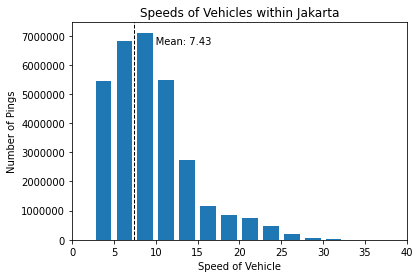

In [ ]:
bins = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40]
plt.ticklabel_format(style='plain')
plt.hist(incity['speed'].compute(), rwidth = 0.75, bins = bins)
plt.xlim(0, 40)

plt.axvline(avgspeedin, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.title("Speeds of Vehicles within Jakarta")
plt.xlabel("Speed of Vehicle")
plt.ylabel("Number of Pings")

plt.text(avgspeedin*1.1, max_ylim*0.9, '     Mean: {:.2f}'.format(avgspeedin))

plt.show()

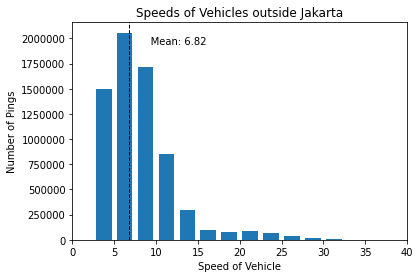

In [ ]:
bins = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40]
plt.ticklabel_format(style='plain')
plt.hist(outcity['speed'].compute(), rwidth = 0.75, bins = bins)
plt.xlim(0, 40)

plt.axvline(avgspeedout, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.title("Speeds of Vehicles outside Jakarta")
plt.xlabel("Speed of Vehicle")
plt.ylabel("Number of Pings")

plt.text(avgspeedout*1.1, max_ylim*0.9, '     Mean: {:.2f}'.format(avgspeedout))

plt.show()

In [ ]:
!pip install researchpy --user

As the p-value is less than 0.99, we can reject the null hypothesis at a 99% confidence level. This implies that the difference in speeds within Jakarta and outside of Jakarta is significant at a 99% confidence level.

In [ ]:
from researchpy import ttest
ttest(group1 = incity["speed"].compute(), group2 = outcity["speed"].compute(), group1_name = "Speeds within Jakarta", group2_name = "Speeds outside Jakarta")


(                 Variable           N      Mean  ...        SE  95% Conf.  Interval
 0   Speeds within Jakarta  36983349.0  7.431658  ...  0.000890   7.429914  7.433402
 1  Speeds outside Jakarta   8224410.0  6.822676  ...  0.001632   6.819476  6.825875
 2                combined  45207759.0  6.317586  ...  0.000789   6.316039  6.319133
 
 [3 rows x 7 columns],
                                   Independent t-test       results
 0  Difference (Speeds within Jakarta - Speeds out...  6.090000e-01
 1                              Degrees of freedom =   4.520776e+07
 2                                               t =   5.899742e+02
 3                           Two side test p value =   0.000000e+00
 4                          Difference < 0 p value =   1.000000e+00
 5                          Difference > 0 p value =   0.000000e+00
 6                                       Cohen's d =   1.188000e-01
 7                                       Hedge's g =   1.188000e-01
 8                     

**Possible Impact on ETA:**

Given that the number of data points originating from within the city, the overall mean speed would be skewed towards the faster average speeds from within Jakarta. 

As a result, the ETA reported on the Grab app to customers might be underestimated based on this overall data, resulting in later ETAs for customers hailing a Grab ride outside of Jakarta.

**Solution:**

Provide more accurate ETA based on the location where the Grab ride is hailed at. For example, when Grab cars are hails outside Jakarta, the ETA must be based of the slower mean speed of cars travelling through this region.

**Areas for further study:**

By subdividing Jakarta into its various districts, one can attempt to look for any further discrepancies in average speed, allowing for a further refinement of ETA within Jakarta itself.

This method can also be further applied to Singapore, by subdividing Singapore into various regions of high traffic (eg. CBD) and low traffic (eg. Lim Chu Kang) to refine ETAs within Singapore.
____________________________________________________________________________

**3) GPS Accuracy within and outside Jakarta**

The accuracy metric measures the margin for error in the accuracy of the GPS reading in metres. So a larger value would mean lower accuracy.

Generally speaking, mean accuracy is better worse within the city compared to outside the city, as given by the higher margin for error in accuracy within the city.

By looking at the heatmap below, we can tell that the accuracy is worse within cities compared to outside cities. The red regions are places with poorer accuracy while the blue regions are places with better accuracy.

We can also visualise this by looking at the histograms below.

In [ ]:
import dask.bag as db
import folium
from folium.plugins import HeatMap
import branca.colormap
from collections import defaultdict

npart = round(len(df)/1000)
parted_df = df.repartition(npartitions=npart)

lat = db.from_sequence(parted_df.partitions[4]['rawlat'], npartitions=5)
lng = db.from_sequence(parted_df.partitions[4]['rawlng'], npartitions=5)
weights = db.from_sequence(parted_df.partitions[4]['accuracy'], npartitions=5)

avg_weights = float(weights.mean())
norm_weights = [float(i)/avg_weights for i in weights]
gradient={'0.99':'Red', '0.95':'Yellow','0.85':'Green', '0.60':'Blue','0.5': 'Navy'}

map = folium.Map(location=[-6.214015, 106.843735],
           zoom_start = 11.2)
heatmaplayer = HeatMap(list(zip(lat, lng, norm_weights)), gradient = gradient)
heatmaplayer.add_to(map)

coordinates = [
    [-6.08838, 106.72357],
    [-6.09611, 106.68944],
    [-6.16894, 106.68992],
    [-6.19557, 106.72288],
    [-6.22219, 106.72013], 
    [-6.23857, 106.7476],
    [-6.31543, 106.77864],
    [-6.31475, 106.80885],
    [-6.36184, 106.79237],
    [-6.33659, 106.85005],
    [-6.37003, 106.89399],
    [-6.35979, 106.91871],
    [-6.29905, 106.91871],
    [-6.26083, 106.90223],
    [-6.25196, 106.94206],
    [-6.211, 106.96266],
    [-6.09133, 106.97097],
    [-6.10021, 106.88301],
    [-6.12206, 106.8116],
    [-6.08838, 106.72357]]

jakarta_line = folium.PolyLine(locations = coordinates, weight = 5, colour = 'black')
map.add_child(jakarta_line)

map

In [ ]:

incityacc = incity[incity.accuracy <= 20]
outcityacc = outcity[outcity.accuracy <= 20]
meanincityacc = incityacc['accuracy'].compute().mean()
meanoutcityacc = outcityacc['accuracy'].compute().mean()

print(f'Mean accuracy within city: {meanincityacc:.2f}')
print(f'Mean accuracy outside city: {meanoutcityacc:.2f}')

Mean accuracy within city: 5.19
Mean accuracy outside city: 5.67


Text(5.714326572418213, 12398022.0, 'Mean: 5.19')

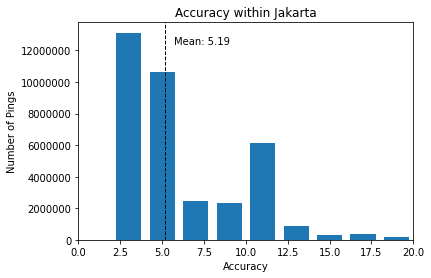

In [ ]:
plt.xlim(0, 20)
bins = [2,4,6,8,10,12,14,16,18,20]
plt.ticklabel_format(style='plain')
plt.hist(incity['accuracy'].compute(), rwidth = 0.75, bins = bins)

plt.axvline(meanincityacc, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.title("Accuracy within Jakarta")
plt.xlabel("Accuracy")
plt.ylabel("Number of Pings")

plt.text(meanincityacc*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(meanincityacc))

Text(6.235246086120606, 12398022.0, 'Mean: 5.67')

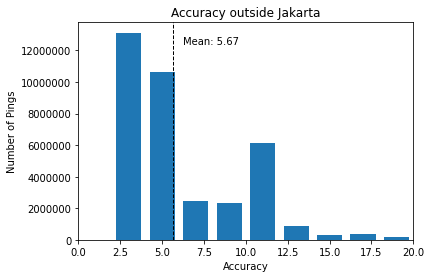

In [ ]:
plt.xlim(0, 20)
bins = [2,4,6,8,10,12,14,16,18,20]
plt.ticklabel_format(style='plain')
plt.hist(incity['accuracy'].compute(), rwidth = 0.75, bins = bins)

plt.axvline(meanoutcityacc, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.title("Accuracy outside Jakarta")
plt.xlabel("Accuracy")
plt.ylabel("Number of Pings")

plt.text(meanoutcityacc*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(meanoutcityacc))

The differences in accuracy within the cities and outside the city is significant at a 99% confidence level. 

In [ ]:
from researchpy import ttest
ttest(group1 = incity["accuracy"].compute(), group2 = outcity["accuracy"].compute(), group1_name = "Accuracy within Jakarta", group2_name = "Accuracy outside Jakarta")

(                   Variable           N  ...  95% Conf.  Interval
 0   Accuracy within Jakarta  36983349.0  ...   5.592593  5.608710
 1  Accuracy outside Jakarta   8224410.0  ...   5.934703  5.940312
 2                  combined  45207759.0  ...   5.239774  5.252999
 
 [3 rows x 7 columns],
                                   Independent t-test       results
 0  Difference (Accuracy within Jakarta - Accuracy... -3.369000e-01
 1                              Degrees of freedom =   4.520776e+07
 2                                               t =   7.215150e+01
 3                           Two side test p value =   0.000000e+00
 4                          Difference < 0 p value =   1.000000e+00
 5                          Difference > 0 p value =   0.000000e+00
 6                                       Cohen's d =  -1.490000e-02
 7                                       Hedge's g =  -1.490000e-02
 8                                   Glass's delta =  -1.350000e-02
 9                         

**Possible Impact on ETA:**

Given that the  data points outside the city have a poorer GPS accuracy, the ETA estimations outside the city might have a larger margin for error, resulting in underestimations in arrival timings.

**Solution:**

Provide a disclaimer to the customer about the possible margin of error in timing, calculated based on the last ping and cumulative effect of this inaccuracy since the last ping. This is to help customers avoid disappointment by letting them known about the margin for error in the ETA. 

For easier comprehension of the disclaimer, the margin for error should be presented in maximum and minumum minutes deviation from the expected time of arrival. 

**Areas for further study:**

The reason behind this drop in GPS accuracy outside the city has to be explored, as generally a drop is expected within cities. This is as cities are more likely to have obstructive buildings that block GPS signals. 

One possible reason could be natural formations like Mount Salak and Mount Pangrango, which might be blocking GPS signals near the outskirts of Bogor. Another possible reason might have to do with tree cover due to extensive plantations or cloud cover outside the city.

By looking into this, Grab can explore possible options to resolve this issue by tackling its root cause. This is important as the current solution only works around the issue.